# LSTM With HPO

- 5-Fold CV with HPO
- 3 Metrics: MAPE, RMSE, MAE
- Predict 24 hours in the future using examples of the past 7 days
- Hourly temperature averages
- Minute detail weather data from a Berlin weather station
- Test set is the 2025 weather data (not yet scraped)

(BME860 sensor data published to a friend's website, see scraping script for details)

In [48]:
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch.nn.init as init
from tqdm import tqdm

Setup

In [49]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU name: Tesla V100S-PCIE-32GB


In [ ]:
# Read in data
years = ["2024"]
columns = ["ISO Time", "Temperature (C)", "Humidity (%)", "Pressure (kPa)", "Air Quality (Ohms)"]
all_data = pd.read_csv("../data/2023_BME680SensorData.csv", usecols=columns)

for year in years:
    data_filename = f"../data/{year}_BME680SensorData.csv"
    read_in_data = pd.read_csv(data_filename, usecols=columns)
    all_data = pd.concat([all_data, read_in_data], ignore_index=True)

print("Data Collected")
all_data.head()


all_data["ISO Time"] = pd.to_datetime(all_data["ISO Time"])
all_data.set_index("ISO Time", inplace=True)
hourly_avg = all_data.resample("H").mean()

Data Collected


<Figure size 1400x500 with 0 Axes>

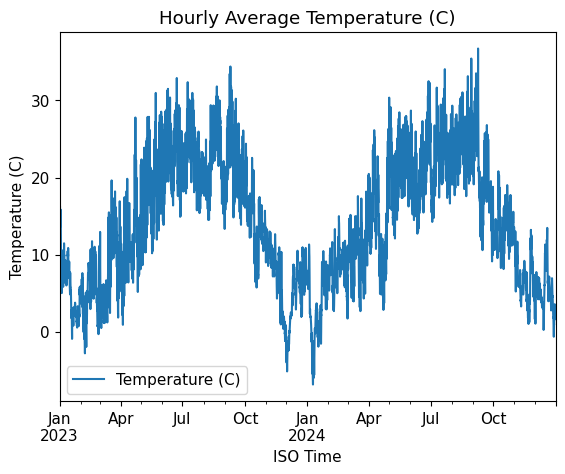

<Figure size 1400x500 with 0 Axes>

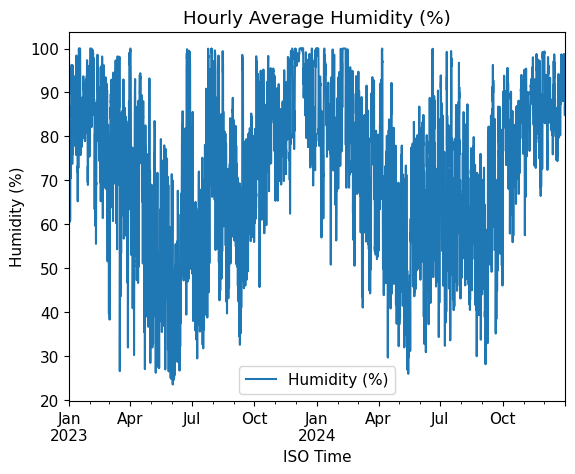

<Figure size 1400x500 with 0 Axes>

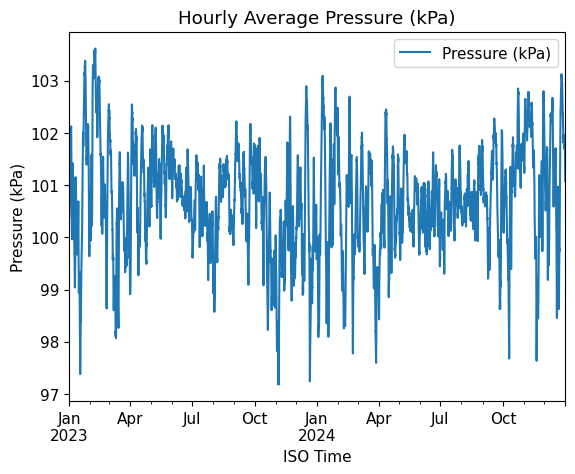

<Figure size 1400x500 with 0 Axes>

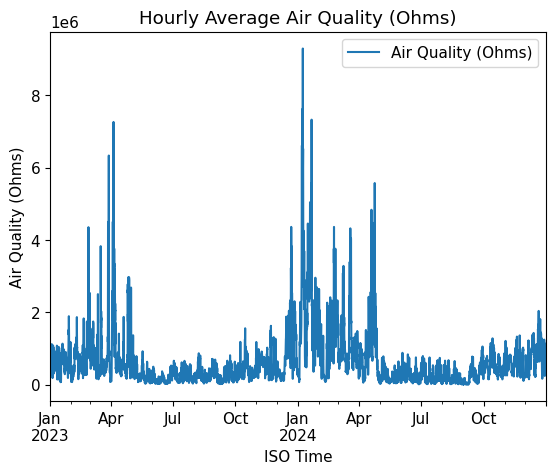

In [51]:
var_names = columns[1:]

for variable in var_names:
    plt.figure(figsize=(14, 5))
    hourly_avg.plot(y=variable)
    plt.title(f"Hourly Average {variable}")
    plt.ylabel(variable)
    plt.show()

In [52]:

print(sum(hourly_avg["Temperature (C)"].isna()))
data = hourly_avg["Temperature (C)"].interpolate(method="linear", limit_direction="both")
data

2


ISO Time
2023-01-01 00:00:00    16.246780
2023-01-01 01:00:00    16.207143
2023-01-01 02:00:00    16.215254
2023-01-01 03:00:00    16.012833
2023-01-01 04:00:00    15.748305
                         ...    
2024-12-31 19:00:00     3.260667
2024-12-31 20:00:00     3.269362
2024-12-31 21:00:00     3.188462
2024-12-31 22:00:00     3.008491
2024-12-31 23:00:00     2.883103
Freq: H, Name: Temperature (C), Length: 17544, dtype: float64

Read in and set up test set

In [ ]:
test_data = pd.read_csv("../data/2025_BME680SensorData.csv", usecols=columns)
test_data["ISO Time"] = pd.to_datetime(test_data["ISO Time"])
test_data["Date"] = test_data["ISO Time"].dt.date
test_data["Hour"] = test_data["ISO Time"].dt.hour
hourly_avg_test = test_data.groupby(["Date", "Hour"]).mean()
hourly_avg_test

time_index = hourly_avg_test.index.to_series().sort_values().reset_index(drop=True)
test_data = hourly_avg_test["Temperature (C)"]

# Reset the index so you can combine Date and Hour into a single datetime column
test_data = test_data.reset_index()
test_data['datetime'] = pd.to_datetime(test_data['Date']) + pd.to_timedelta(test_data['Hour'], unit='h')
test_data = test_data.set_index('datetime')
test_data.drop(columns=["Date", "Hour"], inplace=True)
test_data["Temperature (C)"] = test_data["Temperature (C)"].astype(np.float32)

Model Definition

In [54]:
# Scale Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.to_numpy().reshape(-1,1))

# Hyper Parameters
horizon = 24
look_back = horizon * 7  # 1 week lookback
n_splits = 5
epochs = 50
test_percent = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def create_dataset(dataset, look_back, horizon=24):
    X, y = [], []
    for i in range(len(dataset) - look_back - horizon + 1):
        X.append(dataset[i:i+look_back, 0])                # Input: 168 past hours
        y.append(dataset[i+look_back : i+look_back+horizon, 0])  # Output: next 24 hours sequence
    return np.array(X), np.array(y)


#########
# Train #
#########
X, y = create_dataset(data_scaled, look_back, horizon)

# Add channel dimension before splitting (input shape: (samples, time_steps, 1))
X_train = X[:, :, np.newaxis]  # shape: (N, 168, 1)
y_train = y[:, :, np.newaxis]  # shape: (N, 24, 1)


########
# Test #
########
scaled_test = scaler.transform(test_data.to_numpy().reshape(-1,1))  # Use the train scaler and do not fit anything! -> No leakage

X, y = create_dataset(scaled_test, look_back, horizon)
X_test = X[:, :, np.newaxis]  # shape: (N, 168, 1)
y_test = y[:, :, np.newaxis]  # shape: (N, 24, 1)

# Convert test set to tensors
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=24):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)  # output 24 values at once
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        out, _ = self.lstm(x)           # out shape: (batch, seq_len, hidden_size)
        out = self.dropout(out[:, -1, :])  # take output from last time step only
        out = self.linear(out)          # map to 24 outputs
        out = out.unsqueeze(2)          # reshape to (batch, 24, 1)
        return out

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

def init_weights_glorot(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)  # Glorot uniform
        if m.bias is not None:
            init.zeros_(m.bias)  # Bias can be initialized to zero


cuda


Train

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred, insample):
    """ MASE using naive forecast as denominator (seasonality=1 assumed)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    insample = np.array(insample)
    naive_forecast = np.abs(insample[1:] - insample[:-1])
    denom = np.mean(naive_forecast)
    return np.mean(np.abs(y_true - y_pred)) / denom


def objective(trial):
    # Hyperparameters to tune
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    wt_decay = trial.suggest_float('wt_decay', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = 30
    patience = 5

    tscv = TimeSeriesSplit(n_splits=5)

    mape_folds = []
    rmse_folds = []
    mase_folds = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        X_train_s, X_val_s = X_train[train_idx], X_train[val_idx]
        y_train_s, y_val_s = y_train[train_idx], y_train[val_idx]

        X_train_t = torch.tensor(X_train_s, dtype=torch.float32).to(device)
        y_train_t = torch.tensor(y_train_s, dtype=torch.float32).to(device)
        X_val_t = torch.tensor(X_val_s, dtype=torch.float32).to(device)
        y_val_t = torch.tensor(y_val_s, dtype=torch.float32).to(device)

        train_dataset = TensorDataset(X_train_t, y_train_t)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=horizon).apply(init_weights_glorot).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wt_decay)
        loss_fn = nn.MSELoss()

        best_val_mape = float('inf')
        epochs_no_improve = 0

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                y_pred = model(X_val_t).cpu().numpy()
                y_val_np = y_val_t.cpu().numpy()

                y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
                y_val_inv = scaler.inverse_transform(y_val_np.reshape(-1, 1))

                val_mape = mean_absolute_percentage_error(y_val_inv, y_pred_inv)

            if val_mape < best_val_mape:
                best_val_mape = val_mape
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1} on fold {fold+1}")
                break

        # Final evaluation
        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_t).cpu().numpy()
            y_val_np = y_val_t.cpu().numpy()
            y_train_np = y_train_s

            y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
            y_val_inv = scaler.inverse_transform(y_val_np.reshape(-1, 1))
            y_train_inv = scaler.inverse_transform(y_train_np.reshape(-1, 1))

            rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
            mape = mean_absolute_percentage_error(y_val_inv, y_pred_inv)
            mase_score = mean_absolute_scaled_error(y_val_inv, y_pred_inv, y_train_inv)

            mape_folds.append(mape)
            rmse_folds.append(rmse)
            mase_folds.append(mase_score)

        trial.report(np.mean(mape_folds), fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    trial.set_user_attr("rmse_mean", np.mean(rmse_folds))
    trial.set_user_attr("mase_mean", np.mean(mase_folds))

    return np.mean(mape_folds)  # Still optimizing MAPE, change to mase_folds if needed

# Run the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10, timeout=900)

print("Best trial:")
trial = study.best_trial
print(f"  MAPE: {trial.value:.4f}")
print(f"  RMSE: {trial.user_attrs['rmse_mean']:.4f}")
print(f"  MASE: {trial.user_attrs['mase_mean']:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-21 09:54:03,901] A new study created in memory with name: no-name-f5b4fe8e-ed76-483e-ba4a-e740f36b7dfa


Early stopping at epoch 12 on fold 1
Early stopping at epoch 12 on fold 2
Early stopping at epoch 9 on fold 3
Early stopping at epoch 25 on fold 4


[I 2025-06-21 09:54:29,777] Trial 0 finished with value: 40.12713208794594 and parameters: {'hidden_size': 65, 'num_layers': 1, 'lr': 0.008513973533737033, 'wt_decay': 4.9547568875125634e-05, 'batch_size': 64}. Best is trial 0 with value: 40.12713208794594.


Early stopping at epoch 12 on fold 5
Early stopping at epoch 14 on fold 1
Early stopping at epoch 11 on fold 2
Early stopping at epoch 9 on fold 3
Early stopping at epoch 11 on fold 4


[I 2025-06-21 09:54:51,469] Trial 1 finished with value: 63.95638436079025 and parameters: {'hidden_size': 51, 'num_layers': 1, 'lr': 0.0005079648606624778, 'wt_decay': 0.00545724578647496, 'batch_size': 64}. Best is trial 0 with value: 40.12713208794594.


Early stopping at epoch 16 on fold 5
Early stopping at epoch 6 on fold 1
Early stopping at epoch 7 on fold 2
Early stopping at epoch 8 on fold 3
Early stopping at epoch 6 on fold 4


[I 2025-06-21 09:55:28,296] Trial 2 finished with value: 69.8167273402214 and parameters: {'hidden_size': 73, 'num_layers': 1, 'lr': 0.0029718067484962936, 'wt_decay': 0.0014638455126180284, 'batch_size': 16}. Best is trial 0 with value: 40.12713208794594.


Early stopping at epoch 6 on fold 5
Early stopping at epoch 11 on fold 1
Early stopping at epoch 6 on fold 2
Early stopping at epoch 7 on fold 3
Early stopping at epoch 9 on fold 4


[I 2025-06-21 09:55:46,336] Trial 3 finished with value: 73.66938978433609 and parameters: {'hidden_size': 80, 'num_layers': 3, 'lr': 0.003110130112208203, 'wt_decay': 0.0017366760936761384, 'batch_size': 64}. Best is trial 0 with value: 40.12713208794594.


Early stopping at epoch 6 on fold 5
Early stopping at epoch 8 on fold 1
Early stopping at epoch 8 on fold 2
Early stopping at epoch 6 on fold 3
Early stopping at epoch 19 on fold 4


[I 2025-06-21 09:56:55,798] Trial 4 finished with value: 67.21890896558762 and parameters: {'hidden_size': 72, 'num_layers': 2, 'lr': 0.0020491820596386504, 'wt_decay': 0.0017697515965712173, 'batch_size': 16}. Best is trial 0 with value: 40.12713208794594.


Early stopping at epoch 8 on fold 5


[I 2025-06-21 09:57:00,044] Trial 5 pruned. 


Early stopping at epoch 26 on fold 1
Early stopping at epoch 6 on fold 1
Early stopping at epoch 12 on fold 2
Early stopping at epoch 13 on fold 3
Early stopping at epoch 12 on fold 4


[I 2025-06-21 09:57:35,734] Trial 6 finished with value: 46.25147879123688 and parameters: {'hidden_size': 42, 'num_layers': 2, 'lr': 0.002097445632836334, 'wt_decay': 0.00014358620495442647, 'batch_size': 32}. Best is trial 0 with value: 40.12713208794594.


Early stopping at epoch 7 on fold 5


[I 2025-06-21 09:57:40,550] Trial 7 pruned. 


Early stopping at epoch 16 on fold 1
Early stopping at epoch 20 on fold 1
Early stopping at epoch 23 on fold 2
Early stopping at epoch 13 on fold 3
Early stopping at epoch 13 on fold 4


[I 2025-06-21 09:58:19,766] Trial 8 finished with value: 51.51120483875275 and parameters: {'hidden_size': 41, 'num_layers': 3, 'lr': 0.00019054098942273656, 'wt_decay': 0.0009863153837996153, 'batch_size': 64}. Best is trial 0 with value: 40.12713208794594.


Early stopping at epoch 21 on fold 5


[I 2025-06-21 09:58:21,068] Trial 9 pruned. 


Early stopping at epoch 7 on fold 1
Best trial:
  MAPE: 40.1271
  RMSE: 2.8159
  MASE: 4.3858
  Params:
    hidden_size: 65
    num_layers: 1
    lr: 0.008513973533737033
    wt_decay: 4.9547568875125634e-05
    batch_size: 64


Get best model

In [60]:
best_params = trial.params

model = LSTMModel(
    input_size=1,
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    output_size=horizon
).apply(init_weights_glorot).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['wt_decay'])
loss_fn = nn.MSELoss()

# Train on all available data - We have the CV loss for this model too.
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

# this could be automated but it was faster o do it manually-- choose epochs as mean of early stopping epochs of best HPO trial
epochs = int(np.mean([12, 12, 9, 25, 12]))

# Train the model
model.train()
for epoch in range(epochs):
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

Evaluation

In [61]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t).cpu().numpy()
    y_true = y_test_t.cpu().numpy()

# Reshape to 1D for inverse scaling
y_pred_reshaped = y_pred.reshape(-1, 1)
y_true_reshaped = y_true.reshape(-1, 1)

y_pred_inv = scaler.inverse_transform(y_pred_reshaped).reshape(-1, horizon)
y_true_inv = scaler.inverse_transform(y_true_reshaped).reshape(-1, horizon)



Plots of a week of hourly temperature predictions vs true

Test set metrics

In [62]:
rmse = np.sqrt(mean_squared_error(y_true_inv.flatten(), y_pred_inv.flatten()))
mase = mean_absolute_scaled_error(y_true_inv.flatten(), y_pred_inv.flatten(), insample=scaler.inverse_transform(y_train.reshape(-1, 1)).flatten())
mape = mean_absolute_percentage_error(y_true_inv.flatten(), y_pred_inv.flatten())

print(f'Test RMSE: {rmse:.4f}')
print(f'Test MASE: {mase:.4f}')
print(f'Test MAPE: {mape:.2f}%')

Test RMSE: 2.2229
Test MASE: 3.2903
Test MAPE: 57.61%


Plot (Cold Times)

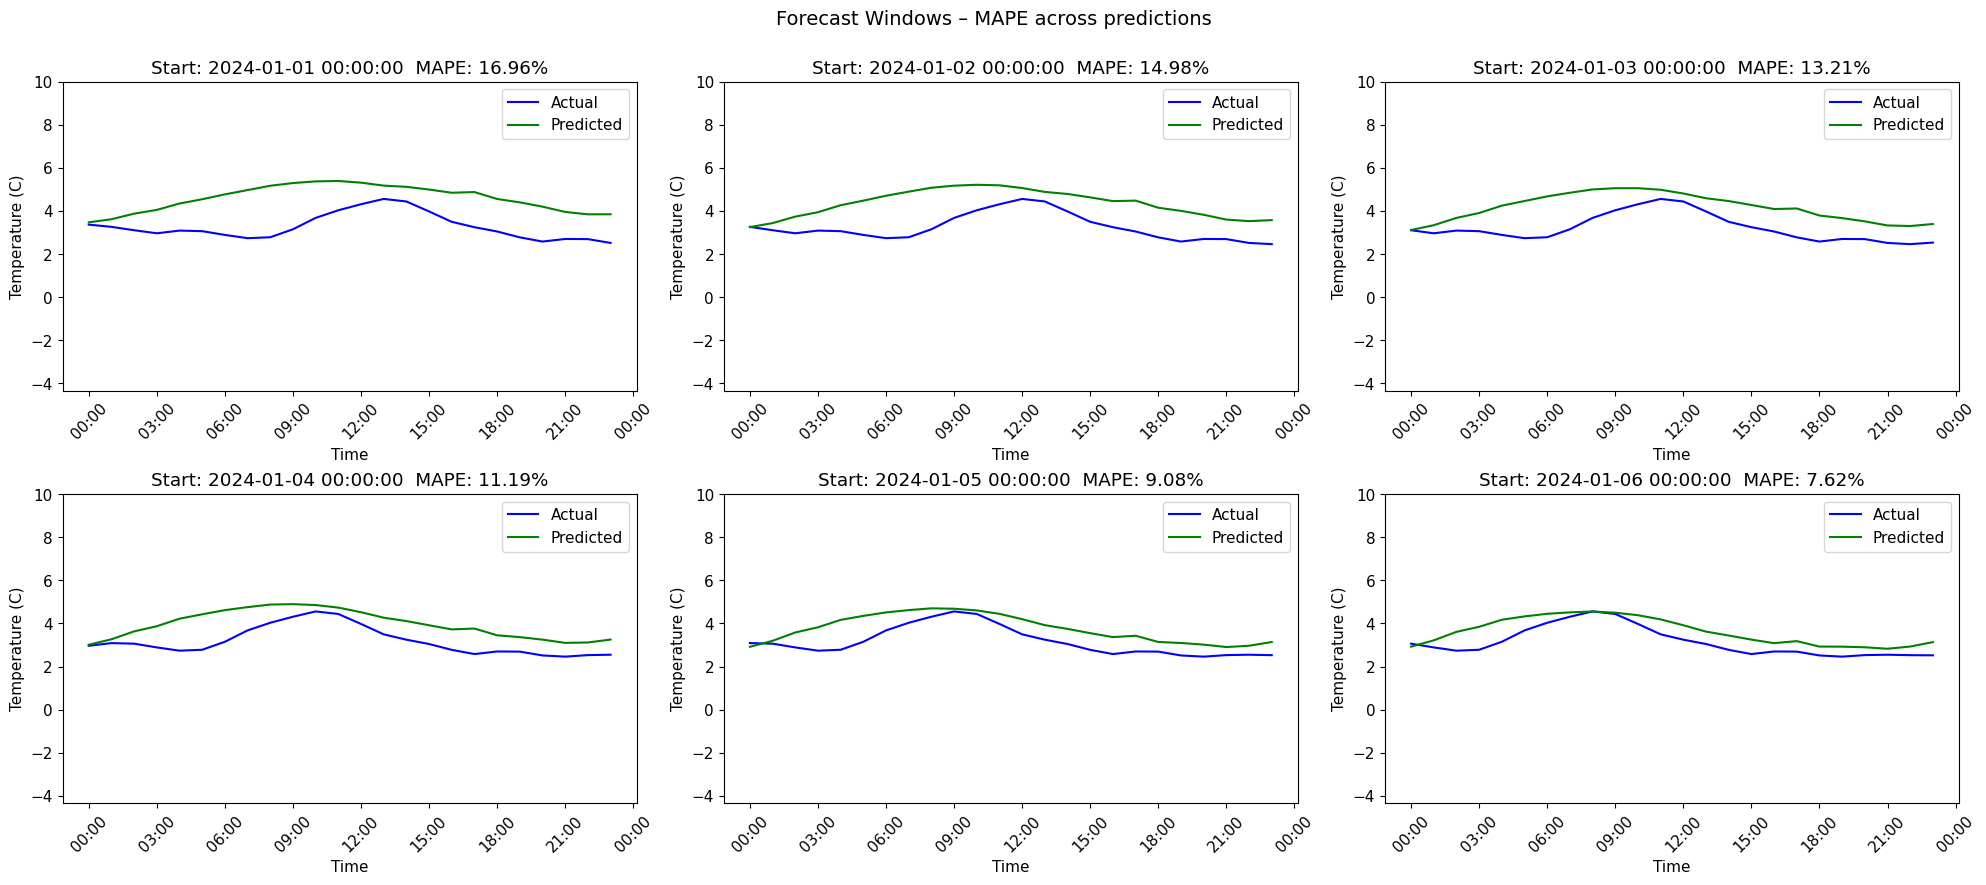

In [ ]:
horizon = 24        # Number of time steps per forecast
offset = 0          # Starting forecast block
numplots = 6        # How many forecast windows to plot

# time_index must match length of test_data
start_time = pd.Timestamp("2024-01-01 00:00")  # Adjust as needed
time_index = pd.date_range(start=start_time, periods=len(test_data), freq="H")

# Ensure y_pred and test_data are on the same scale
y_pred = y_pred_inv.flatten()
test_data = y_true_inv.flatten()

# Limits 
y_min = min(0, y_pred.min())
y_max = 10  #max(test_data.max(), y_pred.max())

plt.figure(figsize=(20, 9))
plt.rcParams.update({'font.size': 11})
date_formater = mdates.DateFormatter('%H:%M')

for idx in range(numplots):
    t_idx = offset + idx
    start = t_idx * horizon
    end = start + horizon
    if end > len(test_data):
        break

    actual_window = test_data[start:end]
    pred_window = y_pred[start:end]
    time_window = time_index[start:end]

    smape = np.mean(
        np.abs(actual_window - pred_window) / (np.abs(actual_window) + np.abs(pred_window) + 1e-8)
    ) * 100  # added epsilon to avoid division by zero



    ax = plt.subplot(2, 3, idx + 1)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"Start: {time_window[0]}  MAPE: {smape:.2f}%")
    ax.plot(time_window, actual_window, label="Actual", color='b')
    ax.plot(time_window, pred_window, label="Predicted", color='g')
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_xlabel('Time')
    ax.set_ylabel('Temperature (C)')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Forecast Windows - MAPE across predictions", fontsize=14)
plt.show()